# Colorado covid projections using realtime update of R0

In [1802]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import emcee
import pandas as pd
from scipy import integrate

In [1803]:
us_confirmed = pd.read_csv('/Users/kulkarniad/corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
us_deaths = pd.read_csv('/Users/kulkarniad/corona/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')

In [1804]:
def raw_data(state):
    df = us_confirmed[us_confirmed['Province_State'] == state]
    confirmed = df.sum(axis=0)
    confirmed = confirmed[11:] # skip metadata
    confirmed = pd.DataFrame(confirmed,columns=['confirmed'])
    
    df = us_deaths[us_deaths['Province_State'] == state]
    deaths = df.sum(axis=0)
    deaths = deaths[12:] # skip metadata
    deaths = pd.DataFrame(deaths,columns=['deaths'])
    
    df = pd.concat([confirmed,deaths], axis=1)
    
    
    df = df[(df.T != 0).any()] # start at the first confirmed case
    return df

def smooth_data(state,window = 7):
    df = us_confirmed[us_confirmed['Province_State'] == state]
    confirmed = df.sum(axis=0)
    confirmed = confirmed[11:].diff()  # skip metadata
    confirmed = pd.DataFrame(confirmed,columns=['confirmed'])
    
    df = us_deaths[us_deaths['Province_State'] == state]
    deaths = df.sum(axis=0)
    deaths = deaths[12:].diff()  # skip metadata
    deaths = pd.DataFrame(deaths,columns=['deaths'])
    
    df = pd.concat([confirmed,deaths], axis=1)
    
    
    df = df[(df.T != 0).any()] # start at the first confirmed case
    df = df.rolling(window=window).mean() # rolling mean window to smoothen out data
    df = df[window:].round()
    df = df.clip(lower = 1)
    return df

In [1805]:
colorado = smooth_data('Colorado')

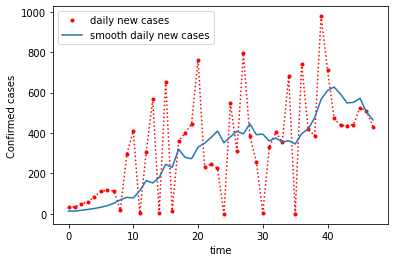

In [1806]:
plt.plot(np.diff(raw.confirmed.values)[9:], 'ro',markersize = 3,label = 'daily new cases')
plt.plot(np.diff(raw.confirmed.values)[9:], 'r:')
plt.plot(np.arange(len(colorado)),colorado.confirmed,label = 'smooth daily new cases')
plt.xlabel('time')
plt.ylabel('Confirmed cases')
plt.legend()
plt.show()

In order to reduce the noise in our predictions, we smooth the number of daily cases by rolling mean window of 7 days. 

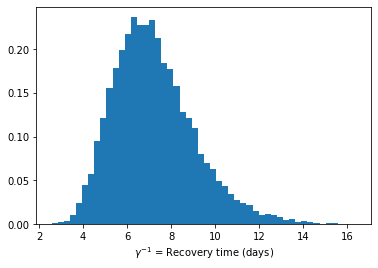

In [1848]:
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282-f1
s, loc, scale = 0.25,0,7
gamma = stats.lognorm.rvs(s,loc,scale,size=10000)
gamma = 1/gamma
plt.hist(1/gamma,bins=50,density=True)
plt.xlabel('$\gamma^{-1}$ = Recovery time (days)')
plt.show()

$\gamma$ is not a single number, rather it's a random variable. In the SIR model, $\gamma^{-1}$ equals the recovery time for an infected patient. According the CDC, recovery times have been observed to have the [following distribution](https://wwwnc.cdc.gov/eid/article/26/7/20-0282-f1). In this work, we model it with a log-normal distribution with the parameters above. The resulting distribution for recovery times is shown above. From this we calculate:

$\gamma = $ recovery time $^{-1}$ 

In [1849]:
# draw gamma from the appropriate log-normal distribution
def draw_gamma():
    s, loc, scale = 0.25,0,7
    gamma = stats.lognorm.rvs(s,loc,scale)
    return 1/gamma
    

In [1850]:
r0_grid = np.linspace(0,5,num=1000)

In [1851]:
def newcases(yesterday_cases,gamma,R):
    out = yesterday_cases
    out *= np.e**(gamma*(R-1))
    return out



In [1852]:
# compute likelihood -> poisson
def r0_lhood(r0,gamma,yest_nc,today_nc,tol = 1e-6):
    prediction = newcases(yest_nc,gamma,r0)
    lhood = stats.poisson.logpmf(today_nc,prediction + tol)
    return lhood

The ```newcases``` function provides a relationship between today's new cases as a function of yesterday's cases, effective R0 and $\gamma$. This equation comes form [Bettencourt, Ribeiro 2008](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185)

Given this model for the number of cases on a given day, we can compute the liklelihood for observing a given number of cases according the poisson distribution. 

Now we can start our bayesian update in which $R_0$ is continously updated as we get more data. First we compute the likelihood. This is the probablity of observing a number of cases on a given day depending on $R_0$. 

Then there is the prior which refelcts our prior beliefs about $R_0$. On the first day, we use a flat prior. After that, the likelihood for the previous day becomes the prior for the next day. Additionaly, we add a bit of randomness to the prior by widening the prior out by a gaussian. This seems to give better results since the randomness ensures prior information is slowly forgotten after a number of days.

In [1853]:
def bayes_update(confirmed_vals,gamma,sigma=0.2):
    # Compute likelihoods
    likehoods = []
    for i in range(len(colorado)-1):
        yesterday = colorado.confirmed.values[i]
        today = colorado.confirmed.values[i+1]
        pmf = np.e**r0_lhood(r0_grid,gamma,yesterday,today)
        pmf /= np.sum(pmf)
        likehoods.append(pmf)
    likehoods = np.array(likehoods)
    
    
    # Process matrix add random perturbations to the R0 PDF's (sigma is a hyperparameter)

    process_matrix = stats.norm(loc=r0_grid,scale=sigma).pdf(r0_grid[:, None]) 

   
    posteriors = []
    prior = np.ones(len(r0_grid))/len(r0_grid)

    for i in range(len(colorado) - 1):
        posterior = likehoods[i] * prior
        posterior /= np.sum(posterior)
        posteriors.append(posterior)   
        prior = process_matrix @ posterior

    posteriors = np.array(posteriors)
    
    return likehoods,posteriors

Draw a random value of $\gamma$ and compute effective $R_0$ posteriors for each day. The posterior on any given day is the sum of the individual posteriors for each value of $\gamma$...

In [1825]:
likehoods = np.zeros((len(colorado) - 1,len(r0_grid)))
posteriors = np.zeros((len(colorado) - 1,len(r0_grid)))

draws = 1000
for _ in range(draws):
    g = draw_gamma()
    l, p = bayes_update(colorado.confirmed.values,g)
    likehoods += l
    posteriors += p

# Finally normlize again
likehoods/= draws
posteriors/= draws

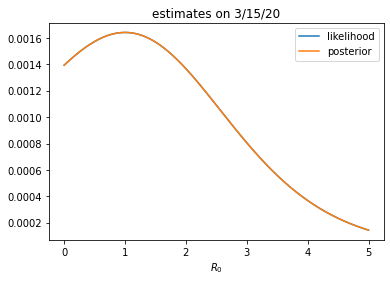

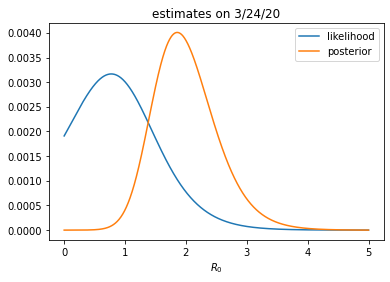

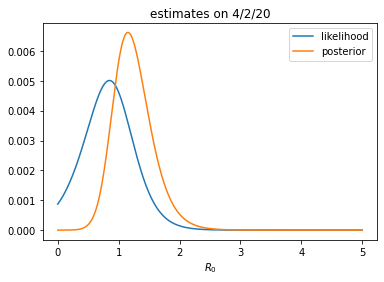

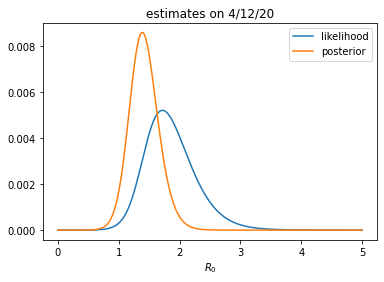

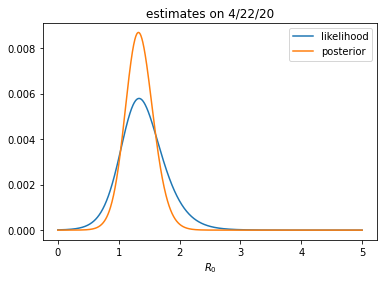

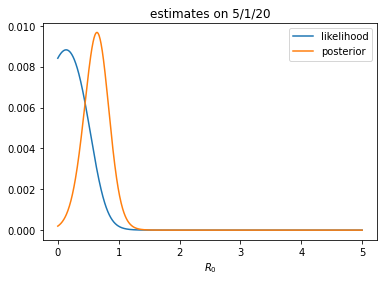

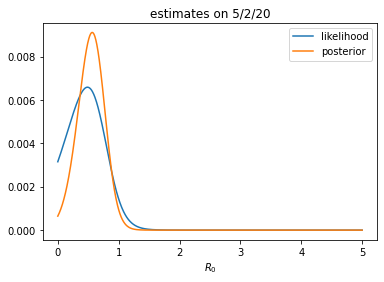

In [1877]:
! rm images/*png
for i in np.append(np.arange(len(colorado))[::9],len(colorado)-2):  
    plt.title('estimates on '+ colorado.index[i+1])
    plt.plot(r0_grid,likehoods[i],label = 'likelihood')
    plt.plot(r0_grid,posteriors[i],label = 'posterior')
    plt.savefig('images/'+str(i)+'.png')
    plt.xlabel('$R_0$')
    plt.legend()
    plt.show()

In [1878]:
def mu_std(dist_array):
    mu = np.sum(dist_array * r0_grid)/np.sum(dist_array)
    
    sigma = (r0_grid - mu)**2 * dist_array
    sigma = np.sqrt(np.sum(sigma))
    
    sigma /= np.sum(dist_array)
    
    return mu,sigma


In [1879]:
mu_list = np.zeros(len(posteriors))
std_list = np.zeros(len(posteriors))

for i in range(len(posteriors)):
    mu_list[i],std_list[i] = mu_std(posteriors[i])
    

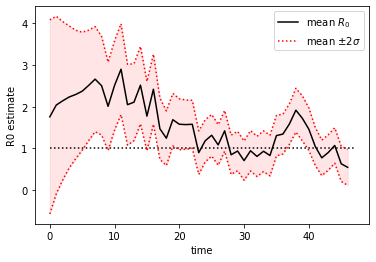

In [1880]:
plt.plot(mu_list,'black',label = 'mean $R_0$')
plt.plot(mu_list + 2*std_list,'r:', label = 'mean $\pm 2 \sigma$')
plt.plot(mu_list - 2*std_list,'r:')

plt.fill_between(np.arange(len(mu_list)),
                 mu_list + 2*std_list,mu_list - 2*std_list, 
                 color = 'red', alpha = 0.1)

plt.hlines(1,0,len(posteriors),linestyle = ':')
plt.xlabel('time')
plt.ylabel('R0 estimate')
plt.legend()
plt.show()


Let's look at the latest posterior:

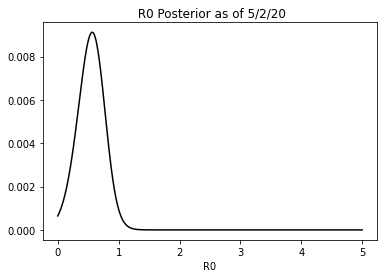

In [1881]:
plt.plot(r0_grid,posteriors[-1],color = 'black')
plt.xlabel('R0')
plt.title(' R0 Posterior as of ' + colorado.index[-1])
plt.show()


Most of the mass is below 1. Great! Using this distribution of R0, we can extrapote to the future...

In [1882]:
# draw R0 from the current posterior using the inverse CDF method

def draw_r0(posterior,size = 1):
    cdf = np.cumsum(posterior)
    cdf /= cdf[-1]
    
    samples = np.zeros(size)
    for i in range(size):
        u = np.random.rand()

        loc = np.argmin(np.abs(cdf - u))
        samples[i] = r0_grid[loc]
        
        
    if size == 1: 
        return samples[0]
    else:
        return samples
    

Text(0.5, 0, 'R0')

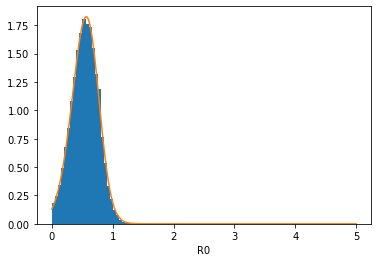

In [1883]:
plt.hist(draw_r0(posteriors[-1],size=100000),bins=30,density=True)
plt.plot(r0_grid,posteriors[-1]*200)
plt.xlabel('R0')

Using these estimates, we can project into the future. There are 2 forms of noise to consider here:
1. Noise due to uncertainty about $R_0$ and $\gamma$
2. Inherent noise due to the poission statistics for cases on any given day

We take both these into account in our extrapolations...

In [1884]:
def extrapolate(r,g,days=20):
    proj = [colorado.confirmed[-1]]
    for i in range(days):
        tomorrow = newcases(proj[-1],g,r) # model prediction
        tomorrow = stats.poisson.rvs(tomorrow) # including poisson noise
        proj.append(tomorrow)
    return np.array(proj)
    

In [1885]:
def plot_projections(preds,**kwargs):
    time = np.arange(len(colorado.confirmed))
    plt.plot(time, colorado.confirmed,'ro',markersize = 3)
    plt.plot(time, colorado.confirmed,'r:')

    
    future_time = np.arange(len(time) -1 ,len(time) + len(preds) -1)
    plt.plot(future_time,preds,**kwargs)

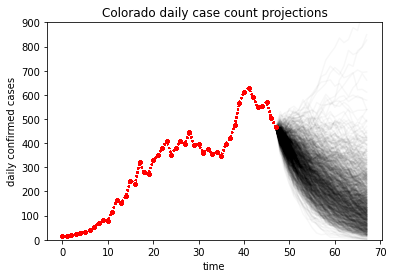

In [1887]:
for _ in range(1000):
    r0 = draw_r0(posteriors[-1])
    g = draw_gamma()
    plot_projections(extrapolate(r0,g),alpha = 0.03,color = 'black')
    plt.ylim(0,900)
plt.ylabel('daily confirmed cases')
plt.xlabel('time')
plt.title('Colorado daily case count projections')
plt.show()



Currently the effective posterior has most of its mass below $R_0 = 1$. Hence we expect the pandemic to die out. Most of these curves are decaying with time. But there are a few that increase since there's still a non-zero chance that $R_0 > 1$

Using our estimate of the number of confirmed cases, we can also estimate the number of deaths...
The case fatality rate is defines as:

$CFR = \frac{\text{deaths}}{\text{confirmed cases}}$ 


We have data on both the numerator and the deniminator. However, these numbers are not 'exact'. Deaths and case count's are random variables and likley follow a poission distribution. We can model this to get a distribution for the CFR

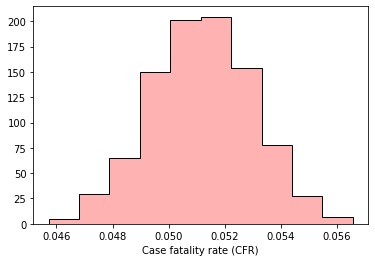

In [1888]:
raw = raw_data('Colorado')
cfr = np.random.poisson(raw.deaths[-1],size = 1000)/np.random.poisson(raw.confirmed[-1],size = 1000)
plt.hist(cfr,color = 'red',alpha = 0.3,density=True)
plt.hist(cfr,color = 'black',histtype = 'step',density=True)
plt.xlabel('Case fatality rate (CFR)')
plt.show()

Colorado's CFR is somewhere around 5%...

In [1889]:
def death_project(r,g,days = 20):
    cfr = np.random.poisson(raw.deaths[-1])/np.random.poisson(raw.confirmed[-1])
    
    future_cases = extrapolate(r,g,days=20)[1:]
    future_deaths = np.cumsum(future_cases) * cfr 
    future_deaths += raw.deaths[-1]  # add in current death toll
    future_deaths = stats.poisson.rvs(future_deaths)
    
    deaths = np.append(raw.deaths.values,future_deaths)

    return deaths
    

Using this case fatality rate we can project the number of deaths outwards.

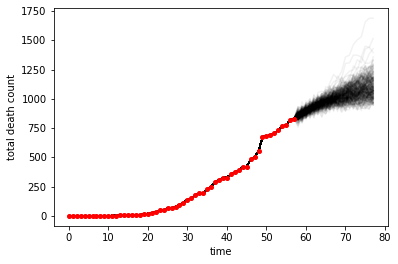

In [1890]:
for i in range(300):
    r = draw_r0(posteriors[-1])
    g = draw_gamma()
    plt.plot(death_project(r,g),alpha = 0.05,color = 'black')
plt.plot(raw.deaths.values,'ro',markersize = 4)
plt.xlabel('time')
plt.ylabel('total death count')
plt.show()

In [1891]:
## TODO:

# Estimate gamma from https://wwwnc.cdc.gov/eid/article/26/7/20-0282-f1
# Show how real-time estimation works in colorado coronavirus. Atleast allows us a way to validate data.
# IS posterior just the product?
# double check r0 to make sure its what the inverse cdf method is supposed to give
# Is the idea of a process matrix good? Seems like this depends quite significantly on the smoothing
# Play around with the smoothing